In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import api_function as api

In [13]:
# Load Data
company = "GOOG"
start = "2012-01-01"
end = "2021-12-31"

data = api.get_df_stock_daily(company, start, end)

In [14]:
#Prepare Data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train=[]
y_train=[]

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [15]:
#Build the Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
77/77 [==============================] - 4s 31ms/step - loss: 0.0099
Epoch 2/25
77/77 [==============================] - 3s 35ms/step - loss: 0.0016
Epoch 3/25
77/77 [==============================] - 3s 36ms/step - loss: 0.0015
Epoch 4/25
77/77 [==============================] - 3s 38ms/step - loss: 0.0015
Epoch 5/25
77/77 [==============================] - 3s 36ms/step - loss: 0.0016
Epoch 6/25
77/77 [==============================] - 3s 36ms/step - loss: 0.0012
Epoch 7/25
77/77 [==============================] - 3s 36ms/step - loss: 0.0012
Epoch 8/25
77/77 [==============================] - 3s 36ms/step - loss: 0.0013
Epoch 9/25
77/77 [==============================] - 3s 36ms/step - loss: 0.0013
Epoch 10/25
77/77 [==============================] - 3s 36ms/step - loss: 0.0013
Epoch 11/25
77/77 [==============================] - 3s 37ms/step - loss: 0.0011
Epoch 12/25
77/77 [==============================] - 3s 36ms/step - loss: 0.0011
Epoch 13/25
77/77 [==================

In [24]:
'''Test the model accuracy on existing data'''

#Load Test Data
test_start='2020-01-01'
test_end='2022-03-25'
test_data = api.get_df_stock_daily(company, test_start, test_end)

actual_prices=test_data['Close'].values

total_dataset=pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [25]:
# Make Predictions on Test Data
x_test=[]

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)

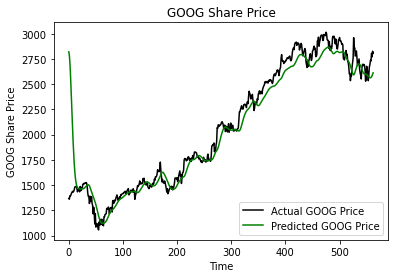

In [26]:
# Plot the test predictions
plt.plot(actual_prices, color = "black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

In [ ]:
#Predict Next Day

real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data=np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction=model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")